In [1]:
import os

import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
a = np.ones(3)

(array([1., 0., 0., 1., 0., 0., 1., 0., 0., 1.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

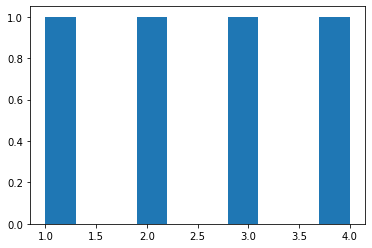

In [14]:
plt.hist(a)

In [8]:
np.hstack((a, np.ones(2)))

array([1., 1., 1., 1., 1.])

In [9]:
a = np.array([1, 2, 3, 4,])

In [11]:
np.where(a>2, 10, 0)

array([ 0,  0, 10, 10])

Setting up a new session...


Random Seed:  999


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

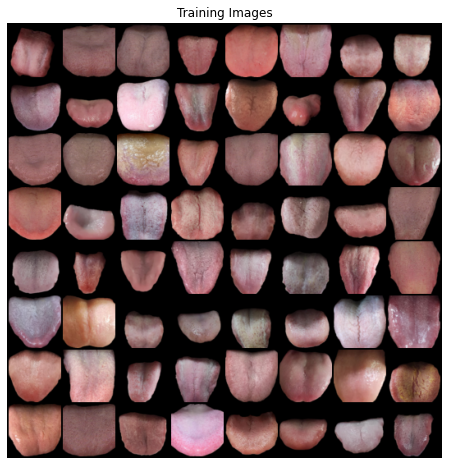

In [13]:
from __future__ import print_function
# %matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from visdom import Visdom
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

viz = Visdom()
viz.line([[0., 0.]], [0], win='train', opts=dict(title='G&D', legend=['G', 'D']))

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot1 = r"D:\MyCodes\pythonProject\coated_tongue_color\my_gan\datas"
dataroot2 = r"D:\MyCodes\pythonProject\coated_tongue_color\my_gan\anomaly_pictures"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset1 = dset.ImageFolder(root=dataroot1,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataset2 = dset.ImageFolder(root=dataroot2,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# creat the dataloader
dataloader1 = torch.utils.data.DataLoader(dataset1, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)
# device which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader1))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))


# 绘图代码
def gen_img_plot(model, epoch, test_input):
    prediction = np.squeeze(model(test_input).detach().cpu().numpy())
    prediction = prediction.transpose(0, 2, 3, 1)
    print(prediction.shape)
    fig = plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow((prediction[i] + 1) / 2)
        plt.axis('off')
    plt.savefig(os.path.join('pictures', str(epoch)))
    plt.show(block=False)
    plt.pause(1)  # 显示1s
    plt.close()


# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.load_state_dict(torch.load(r"D:\MyCodes\pythonProject\coated_tongue_color\my_gan\gan_test\netD.mdl"))
netG.load_state_dict(torch.load(r"D:\MyCodes\pythonProject\coated_tongue_color\my_gan\gan_test\netG.mdl"))
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

real_label = np.array([])
pred_label = np.array([])
normaly = np.array([])
for i, data in enumerate(dataloader1, 0):
    real_cpu = data[0].to(device)
    output = netD(real_cpu).view(-1)
    output = output.cpu().detach().numpy()
    pred_label = np.hstack((pred_label, output))
    real_label = np.hstack((real_label, np.ones(len(output))))
    normaly = np.hstack((normaly, output))

anormaly = np.array([])
for i, data in enumerate(dataloader2, 0):
    real_cpu = data[0].to(device)
    output = netD(real_cpu).view(-1)
    output = output.cpu().detach().numpy()
    pred_label = np.hstack((pred_label, output))
    real_label = np.hstack((real_label, np.zeros(len(output))))
    anormaly = np.hstack((anormaly, output))

pred_label = np.where(pred_label > 0.15, 1, 0)
print(classification_report(real_label, pred_label))
plt.hist(normaly)
plt.hist(anormaly)
plt.show()
plt.savefig("one.png")



In [15]:
import sys
import os

sys.path.append('..\..')
sys.path.append('..')
sys.path.append(r'D:\MyCodes\pythonProject\anormaly_detect\fcdd_master\python\..')
sys.path.append(os.pardir)
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(__file__))))

NameError: name '__file__' is not defined

In [16]:
print(__file__)

NameError: name '__file__' is not defined

[WinError 10054] 远程主机强迫关闭了一个现有的连接。
[WinError 10054] 远程主机强迫关闭了一个现有的连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目

In [17]:
from sklearn.metrics import roc_auc_score

In [29]:
true = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
scores =  [0.017351632937788963, 0.23182041943073273, 0.0006775034707970917
, 0.9202898144721985, 0.8753275275230408, 0.01851571351289749, 8.528785838279873e-05, 7.122906936274376e-06, 4.1343119505654613e-07, 1.683223018744684e-07, 3.095792351359705e-07, 1.2209828526010824e-07, 1.8611245877764304e-07,
5.066546691523399e-06, 3.8286862036329694e-07, 3.304104438939248e-07, 7.931067216304655e-07, 9.06233879049978e-08, 9.427265013073338e-08, 3.1018743129607174e-08, 6.979217204161614e-08
, 8.606181012282832e-08, 4.4551430988803986e-08, 1.0141912554217924e-07, 1.8824120218141616e-07, 1.1069433725197086e-07, 2.784084358609107e-07, 6.948806685613818e-08, 3.7982755429766257e-07, 2.052710925681822e-07, 
4.242269469045823e-08, 4.2726799875936194e-08, 5.706536398975004e-07, 3.725290298461914e-08, 7.557017767112484e-08, 4.7486048515565926e-07, 1.0993407784098963e-07, 5.048148565833799e-08, 4.1510379134024333e-08, 3.953369187570388e-08, 1.578306694227649e-07, 2.049669944881316e-07, 1.1601618155054894e-07, 9.731370909094039e-08, 7.87632785659298e-08, 1.0415607221148093e-07, 3.869740226036811e-07
, 7.237706967089252e-08, 9.868217887287756e-08, 1.0278760242954377e-07, 7.712110914326331e-07, 5.8388224033478764e-08, 3.953369187570388e-08, 1.5813476750281552e-07, 4.7896588029061604e-08, 1.6026351090658864e-07
, 3.93816392829649e-08, 2.5499232947368e-07, 1.0309170761502173e-07, 1.2745053936669137e-06, 3.740495557735812e-08, 2.4057771952357143e-06, 1.0795739058266918e-07, 9.442470627618604e-08, 6.5078538113994e-08
, 9.430306135982391e-07, 3.503293442008726e-07, 3.725290298461914e-08, 1.4642671430920018e-07, 2.913328955855832e-07, 2.310136096639326e-06, 3.259096729379962e-06, 2.1424220619792322e-07, 1.1514948710100725e-05, 
4.033957168303459e-07, 1.163202867360269e-07, 2.9543832624767674e-07, 1.931068851490636e-07, 1.7660917137618526e-06, 4.359349929927703e-07, 2.188493908761302e-06, 5.146982857695548e-07, 1.8364160496275872e-05
, 2.1894063593208557e-06, 5.601619932349422e-07, 6.659906404138383e-08, 5.478457296703709e-07, 4.5281282723408367e-07, 5.080079290564754e-07, 3.6659898228208476e-07, 4.3304598307258857e-07, 8.393307382448256e-08
, 1.2332991445873631e-06, 1.6710588113255653e-07, 1.7972625698803313e-07, 7.106941666279454e-07, 0.0014431908493861556, 7.303089546439878e-07, 2.12493591789098e-06, 1.1730862752301618e-06,
 7.414087690449378e-07, 2.2488589479507937e-07, 9.451441655983217e-06, 2.1405974166555097e-06, 9.84540974968695e-07, 0.00011455830099293962, 2.500658183635096e-06, 1.3712109421248897e-06, 6.488087365141837e-07
, 6.060819259801065e-07, 1.6415606296504848e-06, 7.047640906421293e-07, 5.723262574974797e-07, 2.4115553287629155e-07, 2.876836333598476e-07, 7.924984970486548e-07, 6.857575272078975e-07, 3.4211848287668545e-07
, 3.669030945729901e-07, 9.153570204034622e-07, 4.157119803949172e-07, 5.508867957360053e-07, 2.516471511171403e-07, 2.4693352429494553e-07, 2.0597053662640974e-06, 3.755700959118258e-07, 
6.828685172877158e-07, 0.0014008788857609034, 2.1424220619792322e-07, 3.570196440705331e-07, 9.597564485375187e-07, 9.433347258891445e-07, 4.5144435034671915e-07, 8.11353004337434e-07, 2.764317343917355e-07
, 3.6629486999117944e-07, 0.00012178323959233239, 3.7176877754063753e-07, 4.4961973344470607e-07, 4.683465522248298e-05, 8.514949172422348e-07, 2.790166320210119e-07, 9.959449442931145e-08, 3.1368463737635466e-07
, 6.138366188679356e-07, 9.760260581970215e-07, 1.1698931530190748e-06, 4.2377078557365166e-07, 5.735426498176821e-07, 7.350225814661826e-07, 9.358841452922206e-07, 4.893054779131489e-07, 6.02128579885175e-07
, 5.826657911711663e-07, 8.355294198736374e-07, 2.855549041669292e-07, 2.683729576347105e-07, 7.873287017901021e-07, 5.070652150607202e-06, 6.086668236093828e-07, 3.533703818447975e-07, 9.477442404204339e-07, 
1.0138871857634513e-06, 4.17840738009545e-07, 1.3541809948947048e-06, 7.661629751964938e-06, 1.6081089597719256e-06, 4.181448218787409e-07, 0.0018203940708190203, 1.5689402061980218e-05, 1.702381609902659e-06
, 8.727823228582565e-07, 3.964013046697801e-07, 6.842369657533709e-07, 7.553976502094883e-07, 2.6381138695796835e-07, 4.034109224448912e-06, 3.5397860642660817e-07, 6.501771849798388e-07, 
1.5418140719702933e-06, 1.366953483739053e-07, 6.784589913877426e-06, 3.2706529395909456e-07, 1.8390769582765643e-06, 1.6908256839087699e-07, 6.539785317727365e-07, 2.6989349066752766e-07, 2.75063257504371e-07
, 1.8185498618095153e-07, 5.514646090887254e-06, 4.991888999938965e-07, 3.442472404913133e-07, 7.418649374812958e-07, 2.007095218914401e-07, 2.4434862666566914e-07, 5.177393518351892e-07, 
1.6026351090658864e-07, 4.975163392373361e-07, 3.2463245247527084e-07, 1.15407971179593e-07, 3.258488732171827e-07, 3.264570693772839e-07, 2.639634146817116e-07, 2.0481493834267894e-07, 5.691331352863926e-07
, 3.1763801189299556e-07, 2.2214894102035032e-07, 5.627468908642186e-07, 1.0826149576814714e-07, 1.3274197385726438e-07, 4.2164202795902384e-07, 1.1221487028478805e-07, 
3.266091255227366e-07, 4.599593239618116e-07, 1.0506839487334219e-07, 7.652810722902359e-07, 1.459705600836969e-07, 4.2894058083220443e-07, 1.4129645933280699e-05, 7.401923767247354e-07, 3.329953415232012e-07
, 2.234870180473081e-06, 2.5529643608024344e-06, 5.472375619319791e-07, 3.255447609262774e-07, 2.8205769808664627e-07, 0.0005391906015574932, 1.449061954872377e-07, 2.75063257504371e-07, 0.0018111983081325889
, 1.4755190704818233e-06, 3.6872771147500316e-07
, 1.9477946011647873e-07, 4.5646208945981925e-07, 2.6153057319788786e-07, 2.5879364784486825e-07, 3.898630325238628e-07, 1.6877845609997166e-07, 1.4049666674509353e-07, 6.413581559172599e-07, 9.620372338758898e-07, 
4.135832512019988e-07, 5.139379936736077e-06, 6.795233389311761e-07, 2.531676841499575e-07, 5.892040917387931e-07, 5.324884568835841e-07, 3.995639872300671e-06, 2.642675269726169e-07, 4.190571587514569e-07, 
1.0382156006016885e-06, 4.861123557020619e-07, 2.0739983028761344e-06, 1.7320319329883205e-06, 7.097818297552294e-07, 1.5559548955934588e-06, 7.117585028026951e-07, 1.0316773568774806e-06, 2.0551437955873553e-06, 
1.0741000551206525e-06, 3.7348695514083374e-06, 3.1946265721671807e-07, 0.0043366095051169395, 2.750480689428514e-06, 6.153571234790434e-07, 1.3602631270259735e-06, 1.5279772469511954e-06, 1.074860279004497e-06, 
2.890521102472121e-07, 6.187023018355831e-07, 2.1013678974668437e-07, 6.405978751899966e-07, 9.843889756666613e-07, 1.0902176654781215e-06, 1.918296447911416e-06, 5.556004225582001e-07, 2.0055746574598743e-07, 
2.5879364784486825e-07, 3.16725703441989e-07, 1.3322854783837101e-06, 2.4982253421512723e-07, 5.216926979301206e-07, 6.042573090780934e-07, 4.7045094220266037e-07, 2.048605665549985e-06, 1.8369482859270647e-06, 
1.6497713772878342e-07, 2.3203236310109787e-07, 3.0440943987741775e-07, 1.2057776075380389e-06, 2.805371650538291e-07, 2.110490981976909e-07, 3.138366935218073e-07, 5.521032448996266e-07, 2.434363182146626e-07, 
6.297580694081262e-05, 3.577799247977964e-07, 2.870754371997464e-07, 1.604155670520413e-07, 3.074504775213427e-07, 8.326404099534557e-07, 0.05854390561580658, 6.083627113184775e-07, 2.8555491553561296e-06, 
1.4043583860257058e-06, 0.00012052074453094974, 3.5188027140975464e-06, 5.786516339867376e-06, 0.0003242541279178113, 8.013175261112337e-07, 4.502279296048073e-07, 6.45463558157644e-07, 5.037504706706386e-07, 
1.8597561393107753e-06, 2.408514205853862e-07, 4.825725773116574e-05, 5.708056960429531e-07, 1.6315250661591563e-07, 9.796752920010476e-07, 2.834261749740108e-07, 0.0006468332721851766, 3.4333493204030674e-07,
 4.347185722508584e-07, 1.4365936067406437e-06, 5.458690793602727e-06, 0.00042829220183193684, 3.200708533768193e-07, 4.92498600124236e-07, 1.7060308721283945e-07, 6.410540436263545e-07, 3.8712607874913374e-07, 
3.038772547370172e-06, 7.143434004319715e-07, 8.887478202268539e-07, 1.1484537481010193e-06, 8.078558266788605e-07, 2.46021215843939e-07, 4.921944878333306e-07, 3.276734901191958e-07, 8.7416601672885e-06, 
1.4771916312383837e-06, 1.0129748488907353e-06, 0.02592197246849537, 1.6122144188557286e-06, 3.1947786283126334e-06, 2.221185241069179e-06, 2.0952857937572844e-07, 2.408514205853862e-07, 3.869132342515513e-06, 
3.1915854492581275e-07, 6.057778136892011e-07, 5.303596708472469e-07, 1.535731968260734e-07, 1.6786614764896512e-07, 2.4497205686202506e-06, 2.0633547137549613e-07, 1.9827668040761637e-07, 2.0922446708482312e-07, 
6.805877319493447e-07, 2.923972886037518e-07, 2.8023305276292376e-07, 2.0724777982650266e-07, 1.0008106983150356e-06, 5.729344252358715e-07, 1.7197156410020398e-07, 2.6670036845644063e-07, 3.121641327652469e-07, 
4.459704712189705e-07, 1.6695382498710387e-07, 0.00016229524044319987, 2.376583125851539e-07, 3.7633034821737965e-07, 0.00024887965992093086, 2.6958937837662234e-07, 2.8890005410175945e-07, 8.689809760653588e-07, 
2.8121532523073256e-05, 2.3811446681065718e-07, 0.021347230300307274, 1.3581192433775868e-05, 0.009903487749397755, 5.916369332226168e-07, 6.7587410512715e-07, 7.639125669811619e-07, 0.0007417671731673181,
 7.772932235639018e-07, 3.76178292071927e-07, 7.102379981915874e-07, 1.6908256839087699e-07, 8.697412567926222e-08, 2.4831720111251343e-06, 1.0611755669742706e-06, 1.3395839459917624e-07, 1.9173840826169908e-07, 
9.640139069233555e-07, 3.4342615435889456e-06, 3.012163176663307e-07, 7.593509963044198e-07, 4.0187518379752873e-07, 3.638164116637199e-06, 7.225542617561587e-07, 3.27019665746775e-06, 7.302800804609433e-05, 
2.070044956781203e-06, 1.7562082632593956e-07, 4.747692400997039e-06, 3.161174788601784e-07, 3.859552634821739e-06, 1.7668519092239876e-07, 2.0224524632794783e-06, 3.754180397663731e-07, 2.649821908562444e-06, 
6.986820153542794e-07, 5.6222386774607e-05, 3.720728614098334e-07, 0.00011069692845921963, 8.578811616644089e-07, 1.546375614225326e-07, 3.129928154521622e-05, 6.600606070605863e-07, 2.2853515702081495e-07,
 1.1759752851503436e-06, 0.026820942759513855, 2.4465273895657447e-07, 1.764571152307326e-06, 1.646730396487328e-07, 5.020474873163039e-06, 4.014190437828802e-07, 8.511786290910095e-05, 1.53877294906124e-07,
 1.1784081266341673e-07, 4.075011474924395e-07, 3.2782554626464844e-07, 1.7562082632593956e-07, 0.0002730759442783892, 5.8122739574173465e-05, 1.4750629588888842e-06, 0.00013907405082136393, 0.0369960181415081, 
4.080333383171819e-06, 4.0476419371771044e-07, 1.6786614764896512e-07, 3.100353751506191e-07, 0.0012263715034350753, 4.120627394854637e-08, 4.4171298441142426e-07, 0.015213673003017902, 3.729851982825494e-07, 
0.0001853082503657788, 1.0366950391471619e-06, 2.2610231553699123e-07, 7.760768312436994e-07, 1.2887984439657885e-06, 5.387225883168867e-07, 5.06791536736273e-07, 0.01081299502402544, 1.237708744383781e-07, 
5.499745157067082e-07, 6.973135100452055e-07, 0.003971022088080645, 4.151797838858329e-06, 5.930053958991266e-08, 2.895082786835701e-07, 9.989859961478942e-08, 7.047640906421293e-07, 6.723768706251576e-07, 
2.7875814794242615e-06, 2.784084358609107e-07, 1.715154098747007e-07, 1.1469333003333304e-06, 3.8134808733047976e-07, 1.2650781400225242e-07, 5.21540641784668e-07, 3.031625965377316e-06, 1.9432330589097546e-07, 
1.1373539621217787e-07, 1.143436065831338e-07, 5.352253538148943e-07, 4.272527803550474e-06, 3.956714408559492e-06, 7.040038667582849e-07, 1.1451086265878985e-06, 1.8766339735520887e-06, 0.00037072005216032267, 
9.212870963892783e-07, 2.1080581973365042e-06, 2.007399189096759e-06, 1.4581850393824425e-07, 1.1782560704887146e-06, 4.365431891528715e-07, 2.621387977796985e-07, 4.0719703520153416e-07, 4.809425604435091e-07, 
8.322602297994308e-06, 2.2458178250417404e-07, 1.0162895705434494e-05, 2.650278076998802e-07, 2.689811537948117e-07, 2.1819558071456413e-07, 2.4480479510202713e-07, 3.2128727411873115e-07, 4.515964064921718e-07, 
2.632031623761577e-07, 1.1683574484777637e-05, 9.901517842081375e-06, 6.133804504315776e-07, 4.6011135168555484e-07, 2.4622040655231103e-05, 3.2603131785435835e-06, 0.001024280907586217, 6.303389091044664e-05, 
2.8829185794165824e-07, 8.931573347581434e-07, 1.4004049830873555e-07, 2.481499450368574e-07, 6.15509179624496e-07, 1.5266087416421215e-07, 2.539279648772208e-07, 8.77191837389546e-07, 5.615304985440162e-07, 
2.323364753920032e-07, 2.3142415273014194e-07, 1.9964514308412618e-07, 1.4505823742183566e-07, 3.419664551529422e-07, 1.0360868145653512e-06, 2.9650269084413594e-07, 0.0003193642769474536, 0.0002578569983597845, 
3.828686203632969e-06, 1.6043077266658656e-06, 1.2938009604113176e-05, 6.670550192211522e-07, 9.221994332619943e-07, 6.394726824510144e-06, 2.133146836058586e-06, 5.368979714148736e-07, 5.603140493803949e-07, 
4.4718689196088235e-07, 4.718194190900249e-07, 1.6525083310625632e-06, 1.3206990843173116e-05, 2.6517983542362344e-07, 1.0529647624935023e-06, 1.30157076227988e-07, 3.938164070405037e-07, 5.814493988509639e-07, 
1.5784587503731018e-06, 7.411047135974513e-07, 2.682209014892578e-07, 2.584895355539629e-07, 4.330368756200187e-05, 1.1571207636507097e-07, 2.178914684236588e-07, 3.4211848287668545e-07, 2.0405467182627035e-07, 
9.387594764120877e-05, 5.686769810608894e-08, 1.3896093378207297e-06, 0.2652272582054138, 1.7095280782086775e-06, 1.6094774082375807e-06, 6.447032774303807e-08, 8.773438509024345e-08, 0.00026245779008604586, 
1.2638618045457406e-06, 6.918396167066021e-08, 2.583678906376008e-06, 3.5717170021598577e-07, 3.13000418827869e-06, 6.77698722029163e-07, 3.1119097911869176e-06, 4.070298018632457e-06, 8.97110723485639e-08, 
0.005508228670805693, 4.6117574470372347e-07, 5.251594757282874e-06, 2.4434862666566914e-07, 7.369430386461318e-05, 2.3294468576295912e-07, 2.0116567611694336e-07, 0.7595688104629517, 7.253064268297749e-06, 
0.06481939554214478, 1.873288795195549e-07, 2.049669944881316e-07, 8.986312849401656e-08, 6.857575129970428e-08, 2.527115157135995e-07, 3.390774452327605e-07, 2.099847336012317e-07, 8.013175545329432e-08, 
1.7820572395521594e-07]

In [31]:
roc_auc_score(true, scores)

0.9889267461669505

[WinError 10054] 远程主机强迫关闭了一个现有的连接。
[WinError 10054] 远程主机强迫关闭了一个现有的连接。


In [28]:
scores

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
